In [2]:
%reload_ext autoreload
%autoreload 2
import opt
from spice_net import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Helpers

In [49]:
def train(net: LinearNetwork, xs, ys, epochs, gamma = 0.01, nu = 0.1):
    trainable_mask = np.triu(np.logical_and(net.con_mat == net.con_mat.T, net.con_mat > 0), 1)
    trainable_inds = tuple(np.argwhere(trainable_mask > 0).T)
    n = net.con_mat.shape[0]
    accuracy = np.empty(epochs+1)
    out_nodes = net.node_cfg[1]
    updates = np.empty((epochs, xs.shape[0], np.sum(trainable_mask)))

    # Calculate initial accuracy 
    pred = np.array([net.predict(x) for x in xs])
    accuracy[0] = np.sum((ys - pred)**2)

    for i in range(epochs):
        for j, x, y in zip(range(xs.shape[0]), xs, ys):
            free = net.solve(x)
            
            nudges = nu * y + (1-nu) * free[out_nodes.T[1]]
            clamped = net.solve(x, nudges)

            free_rep = np.tile(free, [n, 1])
            clamped_rep = np.tile(clamped, [n,1])

            delta_free = free_rep - free_rep.T
            delta_clamped = clamped_rep - clamped_rep.T

            update = -gamma * (delta_clamped**2 - delta_free**2)[trainable_mask] # / net.con_mat[trainable_mask]**2 
            net.con_mat[trainable_inds] += update
            net.con_mat.T[trainable_inds] += update
            net.con_mat = np.maximum(net.con_mat, net.epsilon*(trainable_mask + trainable_mask.T))
            update_flat = update.flatten()
            net.update(update_flat)
            updates[i, j] = update_flat

        pred = np.array([-net.predict(x) for x in xs])
        accuracy[i+1] = np.sum((ys - pred)**2)
        print(f'Epoch {i+1}: {accuracy[i+1]}')
        # print(f'Epoch {i}: {pred}')

    return net, accuracy, updates
    
def visualize(net: LinearNetwork):
    G = nx.MultiGraph()
    colors = []
    G.add_nodes_from(net.__nodes__)
    res_mat = np.minimum(np.triu(net.con_mat, k=1), net.con_mat.T) > 0
    for i, coord in enumerate(np.argwhere(res_mat > 0)):
                G.add_edge(*coord, key=i, weight=net.con_mat[coord[0], coord[1]], type='edge')
    # nx.draw_networkx_edges(G, pos, width=2, edgelist=within_edges, edge_color=within_weights, edge_cmap=cm.get_cmap('Reds'),
                            #    edge_vmax=max_weight*1.5, edge_vmin=max_weight*-0.2)
                colors.append('black')
    ne = G.number_of_edges()

    for i, coord in enumerate(np.concatenate(net.node_cfg)):
        G.add_edge(*coord, key=i+ne, weight=1, type='source')
        colors.append('red')

    pos = nx.circular_layout(G)

    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k[:2]: f'R{k[-1]}: {v}' for k, v in nx.get_edge_attributes(G, 'weight').items()})
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v, d in G.edges(data=True) if d['type']=='edge'], edge_color=colors,)#np.log(1e-16 + net.con_mat[res_mat].flatten())/(1e-16 + np.log(1e-16 + net.con_mat.max())), edge_color=colors)
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v, d in G.edges(data=True) if d['type']=='source'], edge_color=colors[ne:], style='dashed')

## Voltage Divider

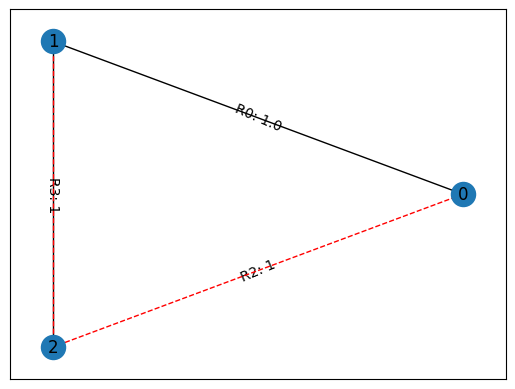

In [53]:
vd = LinearNetwork('voltage_divider', con_mat=np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]], dtype=float), node_cfg=(np.array([[2, 0]]), np.array([[2, 1]])), epsilon=1e-16)
visualize(vd)

In [17]:
dset = {}
dset['x'] = np.array([0, 1, 2, 3, 2, 1])
dset['y'] = dset['x'] / 2

In [18]:
dset

{'x': array([0, 1, 2, 3, 2, 1]), 'y': array([0. , 0.5, 1. , 1.5, 1. , 0.5])}

In [19]:
vd, losses, updates = train(vd, dset['x'], dset['y'], 5, gamma=1)

Epoch 1: 223.5
Epoch 2: 223.5
Epoch 3: 223.5
Epoch 4: 223.5
Epoch 5: 223.5


In [20]:
clamped, free = vd.solve(dset['x'][2], dset['y'][2]), vd.solve(dset['x'][2])
n = clamped.shape[0]
free_rep = np.tile(free, [n, 1])
clamped_rep = np.tile(clamped, [n,1])

delta_free = free_rep - free_rep.T
delta_clamped = clamped_rep - clamped_rep.T

update = -1 * (delta_clamped**2 - delta_free**2) 

In [21]:
delta_clamped**2, delta_free**2

(array([[0., 1., 1.],
        [1., 0., 4.],
        [1., 4., 0.]]),
 array([[0.00000000e+00, 4.00000000e+00, 4.00000013e-32],
        [4.00000000e+00, 0.00000000e+00, 4.00000000e+00],
        [4.00000013e-32, 4.00000000e+00, 0.00000000e+00]]))

In [57]:
[(i, vd.predict(i)) for i in dset['x']]

[(0, array([0])),
 (1, array([1.])),
 (2, array([2.])),
 (3, array([3.])),
 (2, array([2.])),
 (1, array([1.]))]

In [54]:
print(vd)

.title voltage_divider
R0 0 1 1.0
R1 1 2 1.0



In [55]:
updates.shape

(5, 6, 2)

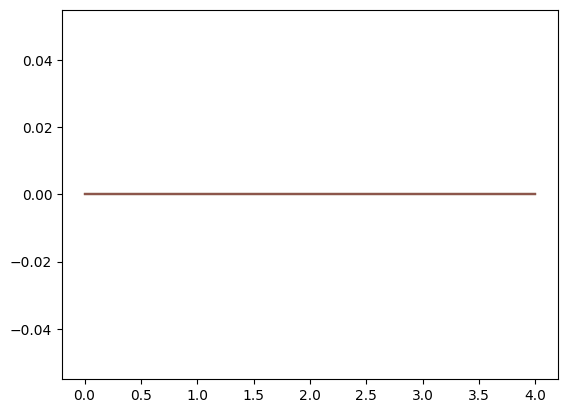

In [52]:
plt.plot(updates[:,:,1])
plt.show()

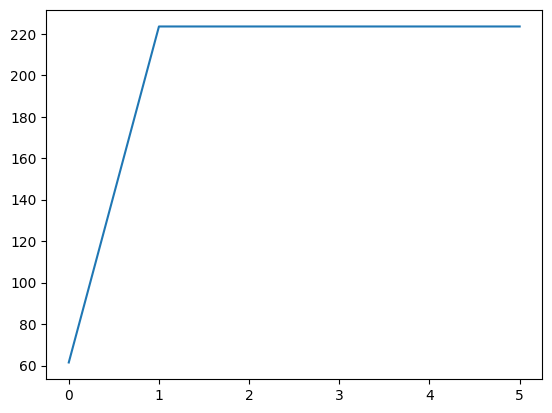

In [26]:
plt.plot(losses)
plt.show()

## Linear Regression

#### Generate the dataset

In [3]:
# Generate N random points
N = 50
split = 0.8
pts = np.random.rand(N)
sigma = 0.2

# Split into training and testing datasets
np.random.shuffle(pts)
training, test = {}, {}
training['x'], test['x'] = pts[:int(N*split)], pts[int(N*split):]

# Generate categories with nonlinear decision boundary
m = np.random.random()
b = np.random.random()

model = lambda x: m*x + b 

training['y'] = model(training['x']) + np.random.normal(0, sigma, training['x'].shape)
test['y'] = model(test['x']) + np.random.normal(0, sigma, test['x'].shape)

Text(0.5, 1.0, 'Dataset with parameters m=0.848, b=0.819, $\\sigma$=0.2')

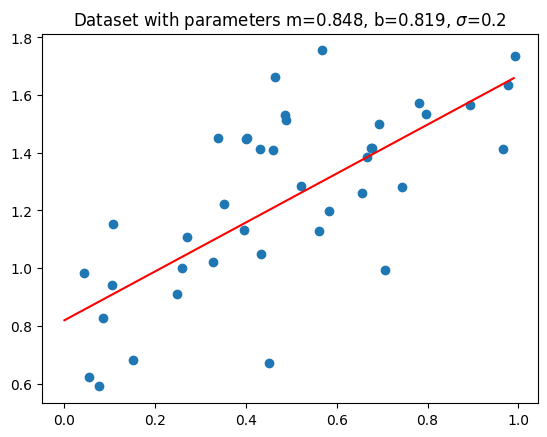

In [4]:
# Visualize dataset
plt.scatter(training['x'], training['y'])
xs = np.arange(0, 1, 0.01)
plt.plot(xs, model(xs), 'r')
plt.title(fr'Dataset with parameters m={round(m, 3)}, b={round(b, 3)}, $\sigma$={sigma}')

#### Generate random linear and nonlinear resistive networks

In [12]:
# Parameters
nodes = 7
density = 5/(nodes-1) # limit average degree to 5
denser = 1.0
diode_thresh = 0.1 # on average each node has 1 diode
mask = np.random.uniform(0, 0.5, (nodes, nodes))
mask = mask + mask.T
con = mask < density
dense = mask < denser
diodes = mask < diode_thresh

In [13]:
# Create the linear network -- initialize random (symmetric) resistor values and apply 
# the connectivity mask
tmp = np.random.rand(nodes, nodes)
lin_network = (tmp + tmp.T) * dense

In [62]:
# Print network statistics:
diag_mask = ~np.eye(lin_network.shape[0]).astype(bool)
edges = np.sum(diag_mask * lin_network > 0)//2
print(f'Linear network edges: {edges}')


Linear network edges: 21


In [86]:
in_nodes = 2
out_nodes = 1
node_cfg = np.concatenate(([0], np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])
node_cfg

(array([[5, 1],
        [4, 0]]),
 array([[6, 3]]))

#### Generate network circuits

In [87]:
lin = LinearNetwork('fully_connected', lin_network, node_cfg)

In [88]:
minimal_mat = np.zeros((nodes, nodes))
minimal_cfg = np.zeros(nodes)
minimal_cfg[1] = 1
minimal_cfg[2] = 1
# minimal_cfg[3] = 1
minimal_cfg[4] = -1
minimal_cfg[5] = -1

# connect inputs to each output with their own tunable resistors
minimal_mat[1, 4] = 1
minimal_mat[1, 5] = 1
minimal_mat[2, 4] = 1
minimal_mat[2, 5] = 1
# minimal_mat[3, 4] = 1
# minimal_mat[3, 5] = 1


# connect both outputs to ground to complete the voltage divider
minimal_mat[4, 0] = 1
minimal_mat[5, 0] = 1
minimal_mat += minimal_mat.T

minimal_net = LinearNetwork('min', minimal_mat, minimal_cfg)

#### Train both networks

In [119]:
lin.con_mat[res_mat]

array([1.17897282e+02, 1.52570317e+02, 1.00000000e-09, 2.28415446e-01,
       1.00000000e-09, 1.69204862e+01, 1.00000000e-09, 1.00000000e-09,
       1.00000000e-09, 1.00000000e-09, 3.08427757e+02, 1.00000000e-09,
       1.00000000e-09, 1.00000000e-09, 8.39434242e+02, 1.00000000e-09,
       1.00000000e-09, 1.43275622e+00, 1.00000000e-09, 3.51201698e+01,
       1.00000000e-09])

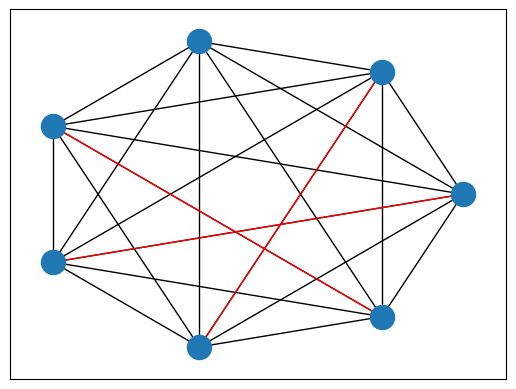

In [236]:
visualize(lin)

Epoch 1: 8231.037037052796
Epoch 2: 8231.037037052796
Epoch 3: 8231.037037052796
Epoch 4: 8231.037037052796
Epoch 5: 8231.037037052796
Epoch 6: 8231.037037052796
Epoch 7: 8231.037037052796
Epoch 8: 8231.037037052796
Epoch 9: 8231.037037052796
Epoch 10: 8231.037037052796


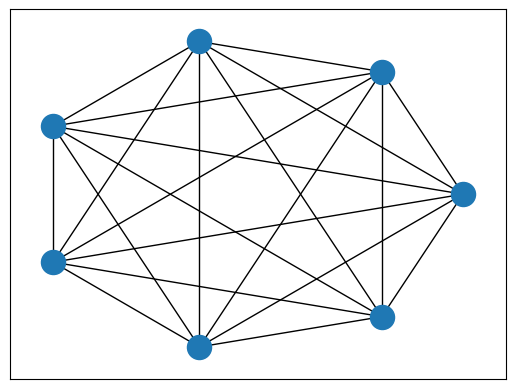

In [233]:
# Train linear network
trained_lin, accuracy, updates = train(lin, dset, training['y'], 10, gamma=10, nu=0.1)
visualize(trained_lin)

In [74]:
lin.solve(training['x'][0])

array([ 5.70906550e-02, -9.08777956e-03, -5.04395254e-02, -1.21485232e-03,
       -6.46329485e-03, -7.09168962e-05,  0.00000000e+00])

In [76]:
lin.predict(training['x'][0])

array([-0.10753018])

In [241]:
# trained_min, accuracy, updates = train(minimal_net, dset, training['y'], 5, gamma=0.1, nu=0.1)

In [229]:
print(lin)

.title fully_connected
R0 0 1 6.058570690978305
R1 0 2 1.0000000038391889e-09
R2 0 3 0.9179006528728384
R3 0 4 1.0000000003616573e-09
R4 1 2 35.78527875331334
R5 1 3 0.09718857040241248
R6 1 4 1e-09
R7 2 3 0.024213427109895408
R8 2 4 1.0000000003616573e-09
R9 3 4 0.09902676941762611



In [100]:
updates.shape

(10, 40, 21)

Text(0.5, 1.0, 'Edge updates')

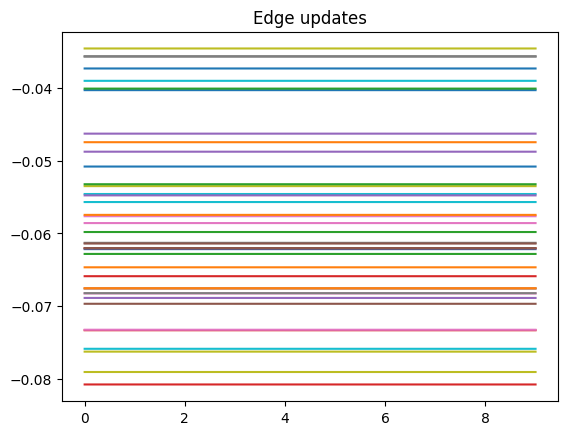

In [101]:
plt.plot(updates[:,:,2])
plt.title('Edge updates')

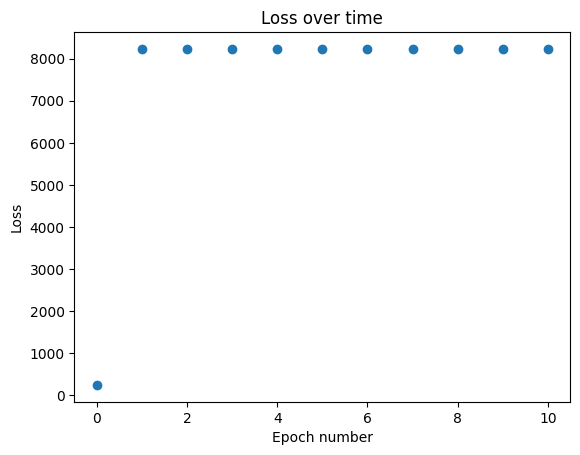

In [102]:
plt.scatter(np.arange(accuracy.size), accuracy)
plt.title('Loss over time')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.show()

In [88]:
print(minimal_net)

NameError: name 'minimal_net' is not defined

In [107]:
xs

array([[0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ]])

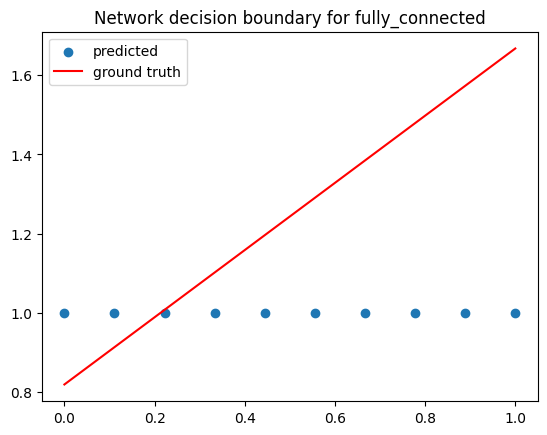

In [111]:
test_net = lin
lh = 1
num_pts = 10
xs = np.linspace(0, lh, num_pts)
ys = [test_net.predict(x) for x in np.stack((np.linspace(0, lh, num_pts), np.ones(num_pts))).T]
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Network decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

In [90]:
print(minimal_net)

NameError: name 'minimal_net' is not defined

In [91]:
# Compare free and clamped results on a single input
plt.scatter(np.arange(10), minimal_net.solve(training['x'][0]))
plt.scatter(np.arange(10), minimal_net.solve(training['x'][0], training['y'][0]))
plt.title('Network outputs')
plt.xlabel('Node number')
plt.ylabel('Node voltage')
plt.legend(['Free state', 'Clamped state'])

NameError: name 'minimal_net' is not defined

In [ ]:
minimal_net.solve(training['x'][0], training['y'][0])

array([0.        , 0.54385602, 0.77809513, 0.        , 0.58470136,
       0.40151283, 0.        , 0.        , 0.        , 0.        ])

#### Compare the networks

In [ ]:
# Evaluate accuracy on training data
lin_outputs = np.array([lin.predict(x) for x in dset])

In [ ]:
predictions, labels = np.argmax(lin_outputs, axis=1), np.argmax(training['y'], axis=1)
lin_acc = np.sum(predictions == labels) / lin_outputs.shape[0]
# relu_acc = np.sum((relu_outputs >= 0.5) == train['y']) / lin_outputs.size
# lin_acc, relu_acc

In [ ]:
lin_acc

0.8

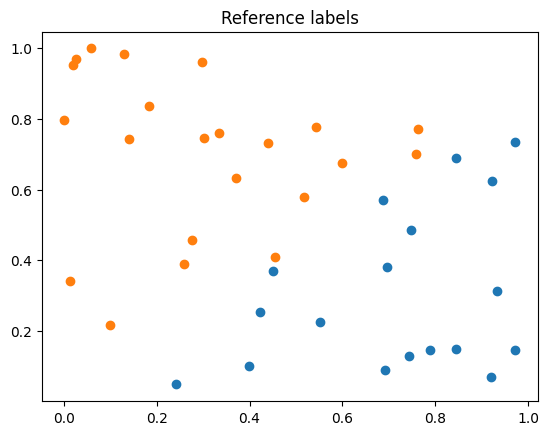

In [ ]:
# Visualize the actual results
plt.scatter(*training['x'][labels.astype(bool).squeeze()].T)
plt.scatter(*training['x'][~labels.astype(bool).squeeze()].T)
plt.title('Reference labels')
plt.show()

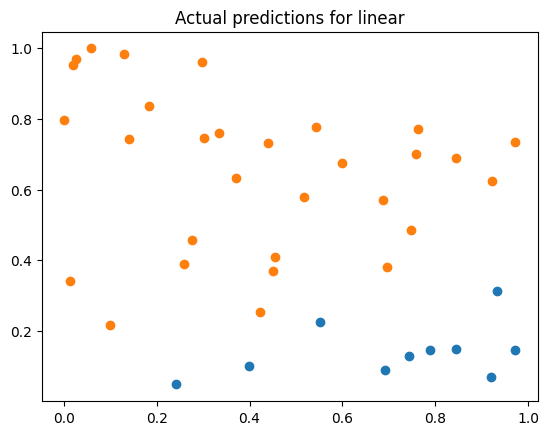

In [ ]:
# Visualize linear network
plt.scatter(*training['x'][predictions.astype(bool)].T)
plt.scatter(*training['x'][~predictions.astype(bool)].T)
plt.title(f'Actual predictions for {test_net.name}')
plt.show()

### Visualize Random Network Performance

In [ ]:
# Generate 
eval_set = np.array(np.meshgrid(np.arange(0, 11), np.arange(0, 11))).reshape(2,-1).T / 10
eval_bias = np.hstack((eval_set, np.ones((eval_set.shape[0], 1))))
N = eval_bias.shape[0]

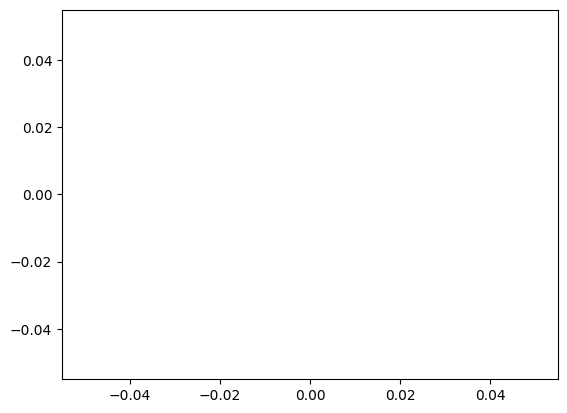

In [ ]:
tmp = np.random.rand(nodes, nodes)
con_mask = (np.random.rand()  < np.random.rand(nodes, nodes))
con_mask = con_mask * con_mask.T
rand_cfg = np.concatenate(([0], np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))))

rand_net = LinearNetwork('rand', (tmp + tmp.T) * con_mask, rand_cfg)

res = np.empty((N, out_nodes))

for i in range(N):
    res[i] = rand_net.solve(eval_bias[i])[rand_cfg < 0]

plt.scatter(*eval_set[res.T[0] < res.T[1]].T)
# plt.scatter(*eval_set[res.T[0] >= res.T[1]].T)

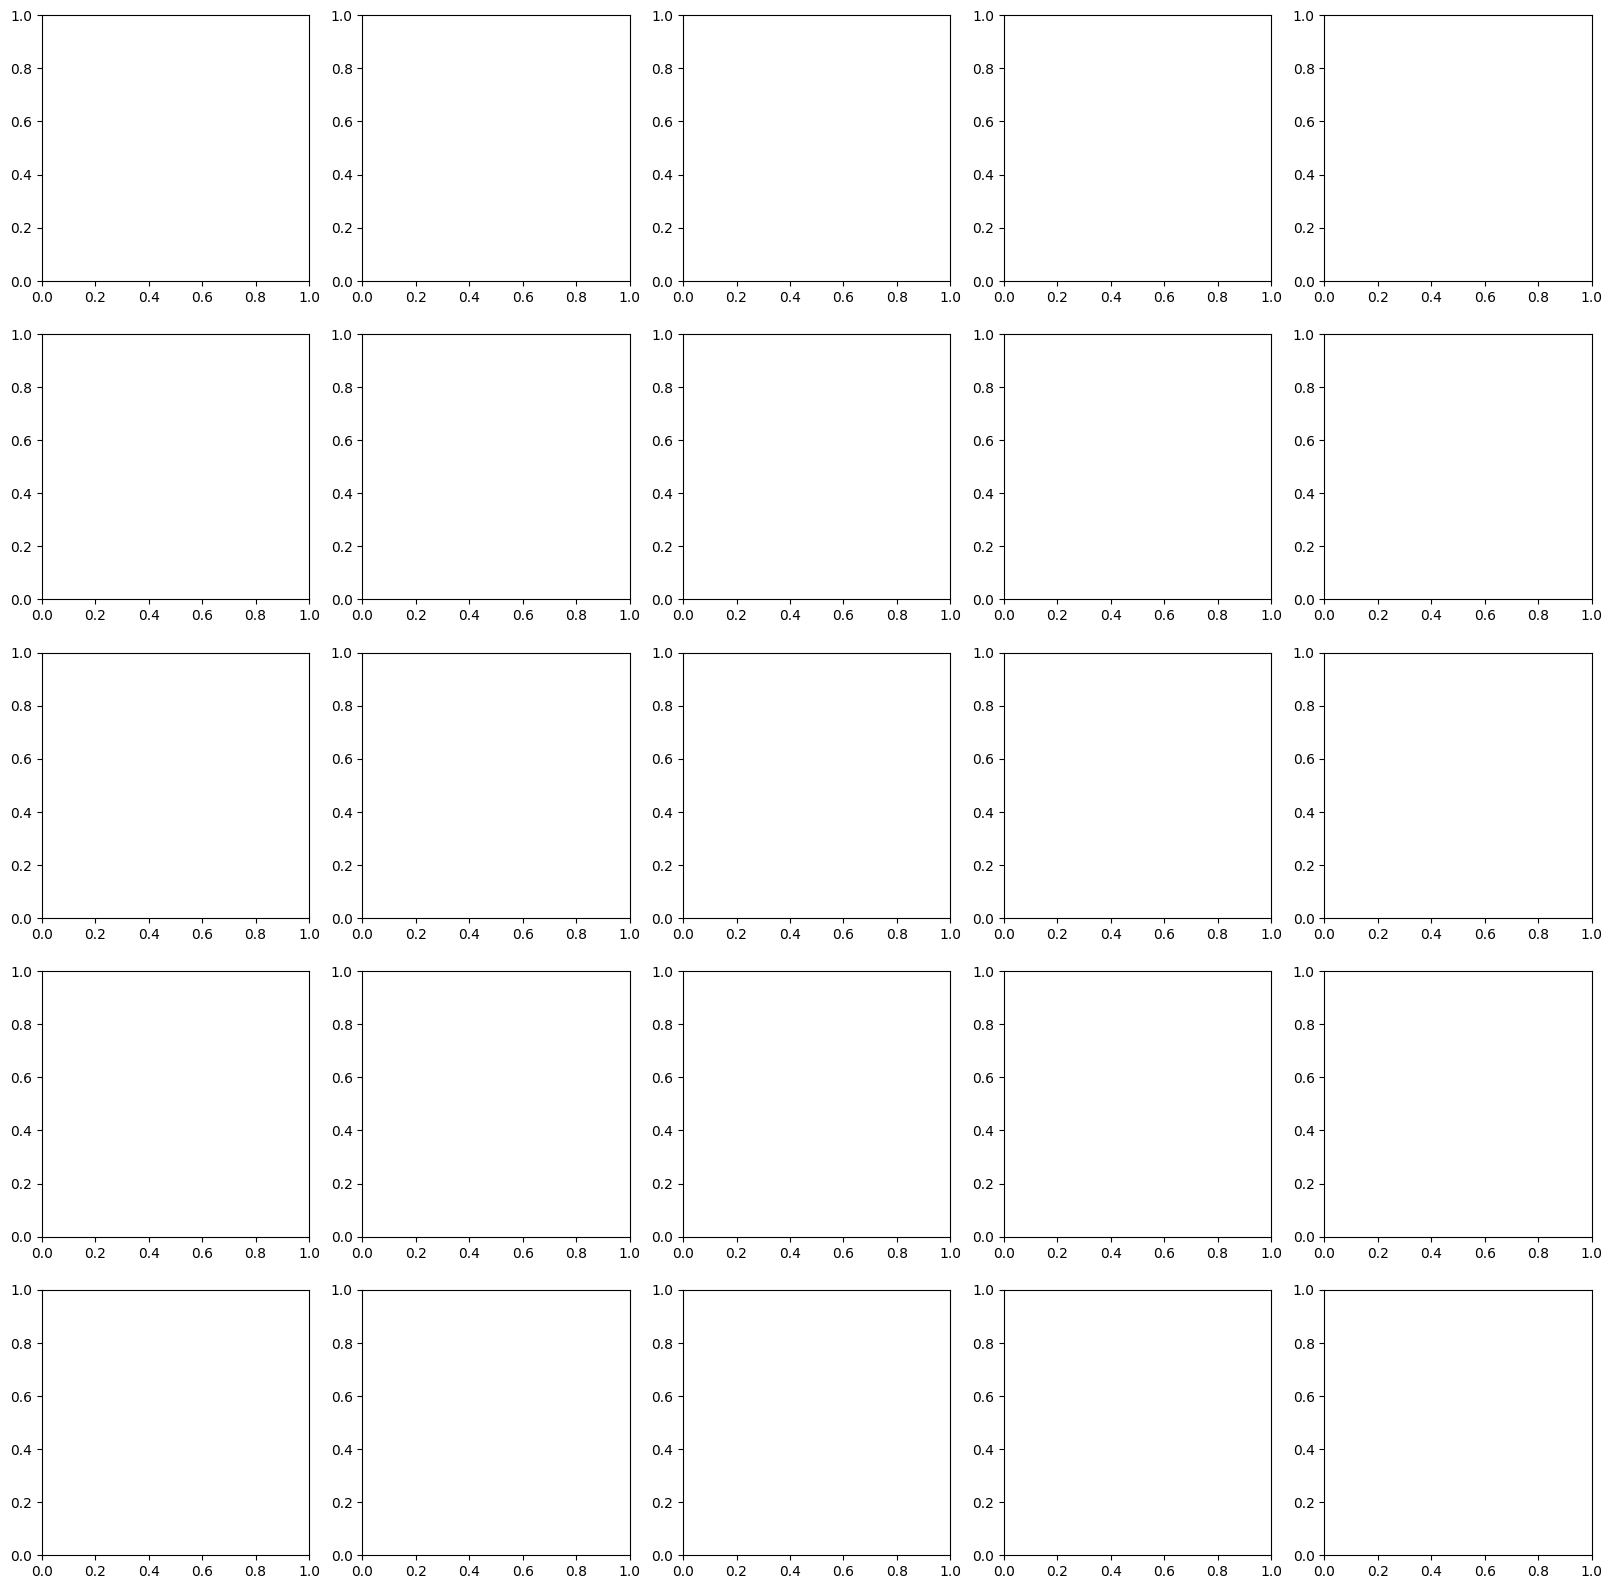

In [ ]:
# Generate a ton of randomly initialized networks and see how they do
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
fig
in_nodes = 3
out_nodes = 2
nodes = 20

nodes_nums = [10, 20, 30, 50, 75]
nodes_values = {}
nets = []

for n in nodes_nums:
    nodes = n
    nodes_values[n] = []
    for row in axs:
        for subp in row:
            tmp = np.random.rand(nodes, nodes)
            con_mask = (np.random.rand()  < np.random.rand(nodes, nodes))
            con_mask = con_mask * con_mask.T
            rand_cfg = np.concatenate(([0], np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))))

            rand_net = LinearNetwork('rand', (tmp + tmp.T) * con_mask, rand_cfg)
            nets.append([(tmp + tmp.T) * con_mask, rand_cfg])

            # cm, nc = nets[j]
            # rand_net = LinearNetwork('rand', cm, nc)
            
            res = np.empty((N, out_nodes))
            for i in range(N):
                res[i] = rand_net.solve(eval_bias[i])[rand_cfg < 0]
            
            nodes_values[n].append(res)
            # # res = res[:2] - res[2:]
            # subp.scatter(*eval_set[res.T[0] < res.T[1]].T)
            # subp.scatter(*eval_set[res.T[0] > res.T[1]].T)
            # subp.scatter(*eval_set[res.T[0] == res.T[1]].T)
            # j += 1

In [ ]:
nets

In [ ]:
sus_net = LinearNetwork('sus', *nets[-1])

In [ ]:
print(sus_net)

.title sus
R0 0 2 0.349827898233006
R1 0 4 1.196368438170716
R2 0 5 0.9407957133122234
R3 0 7 0.8287327797193977
R4 0 9 1.2840057679997932
R5 1 2 1.544486651892592
R6 1 4 0.8877696926219039
R7 1 6 1.143300444686718
R8 1 7 1.2307530363836312
R9 1 8 0.7437506700329561
R10 1 9 1.1889640242577637
R11 2 5 1.3453639266543722
R12 2 6 1.0404516462294726
R13 2 8 0.8836290508469532
R14 2 9 1.701767684004634
R15 3 4 1.1097584846355968
R16 3 5 1.0304838237165077
R17 3 7 1.314204572114678
R18 4 9 1.1315105020541751
R19 5 6 1.5672275910398454
R20 5 9 0.18634147290673608
R21 6 7 1.7096438793487954
R22 6 8 0.6081549069136544
R23 6 9 0.9900999658917478
R24 7 8 0.7871534322277741
R25 7 9 1.884077569613963



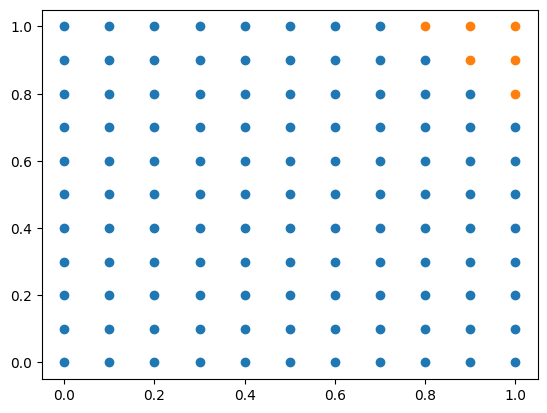

In [ ]:
res = np.empty((N, out_nodes))
for i in range(N):
    res[i] = sus_net.solve(eval_bias[i])[rand_cfg < 0]

plt.scatter(*eval_set[res.T[0] < res.T[1]].T)
plt.scatter(*eval_set[res.T[0] > res.T[1]].T)
plt.scatter(*eval_set[res.T[0] == res.T[1]].T)

In [ ]:
print(sus_net)

.title rand
R0 0 2 0.6665987627849591
R1 0 4 0.5059691368189476
R2 0 5 0.9465677974597428
R3 0 7 1.0940815828794594
R4 0 8 0.450084033992904
R5 0 9 0.5704427470068788
R6 1 2 0.8704110893388182
R7 1 3 1.0265067524102198
R8 1 7 0.990368907126467
R9 1 8 1.252337502091214
R10 1 9 1.1230684385347929
R11 2 3 0.5995202010269257
R12 2 6 1.085911880065543
R13 2 7 0.6819607654074623
R14 2 8 1.1372039446565445
R15 2 9 0.3771505415524653
R16 3 5 0.7091900818706769
R17 3 6 0.56878471972491
R18 4 5 0.9559889498484285
R19 4 6 1.331043612091639
R20 4 7 1.0882881896671344
R21 5 7 1.3021479749325762
R22 5 8 0.9651359164398519
R23 5 9 1.0477164808799522
R24 6 7 0.4934428710129847
R25 6 8 1.2954817984321436
R26 6 9 1.3321073947800977
R27 7 8 1.418903653165053
R28 8 9 0.34265837537905586

